<a href="https://colab.research.google.com/github/kridtapon/WFO-Trend-Flow-Oscillator-TFO-System/blob/main/WFO_Trend_Flow_Oscillator_(TFO)_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.1 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-14-05f9fb84dd80>:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-05f9fb84dd80>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-05f9fb84dd80>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide


Walk-Forward Optimization Results:
   Year      Best_Params  Test_Return
0  2020  (13, 22, 50, 5)     0.252550
1  2021  (15, 20, 60, 5)     0.402259
2  2022  (15, 22, 60, 5)    -0.050207
3  2023  (15, 20, 55, 5)     0.438250
4  2024  (15, 20, 55, 5)     0.424803
5  2025  (19, 20, 50, 5)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           308082.909794
Total Return [%]                        208.08291
Benchmark Return [%]                   170.252574
Max Gross Exposure [%]                      100.0
Total Fees Paid                      16960.742872
Max Drawdown [%]                        32.592925
Max Drawdown Duration                       245.0
Total Trades                                   50
Total Closed Trades                            50
Total Open Trades                               

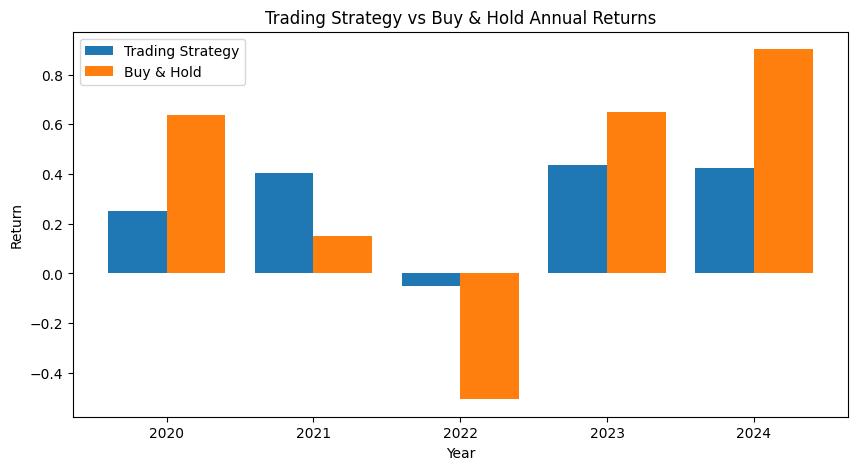

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Volume Zone Oscillator (VZO)
def calculate_vzo(df, period=14):
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    volume_flow = df['Volume'] * np.sign(df['Close'].diff())

    vp = volume_flow.rolling(period).sum()
    total_volume = df['Volume'].rolling(period).sum()

    vzo = (vp / total_volume) * 100
    return vzo

# Function to calculate Klinger Volume Oscillator (KVO)
def calculate_kvo(df, short_period=34, long_period=55, signal_period=13):
    dm = (df['High'] + df['Low'] + df['Close']) / 3
    trend = np.where(dm > dm.shift(1), df['Volume'], -df['Volume'])
    kvo = pd.Series(trend, index=df.index).ewm(span=short_period).mean() - pd.Series(trend, index=df.index).ewm(span=long_period).mean()
    kvo_signal = kvo.ewm(span=signal_period).mean()
    return kvo, kvo_signal

# Walk-forward optimization with VZO + KVO
def walk_forward_optimization_vzo_kvo(df, start_year, end_year):
    results = []

    # Define dynamic ranges for VZO and KVO parameters
    vzo_period_range = range(5, 20, 2)  # Range for VZO periods
    short_period_range = range(20, 41, 2)  # Range for KVO short periods
    long_period_range = range(50, 101, 5)  # Range for KVO long periods
    signal_period_range = range(5, 20, 2)  # Range for KVO signal periods

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of VZO and KVO parameters
        for params in itertools.product(vzo_period_range, short_period_range, long_period_range, signal_period_range):
            vzo_period, short_period, long_period, signal_period = params

            # Calculate VZO and KVO on the training data
            train_data['VZO'] = calculate_vzo(train_data, period=vzo_period)
            train_data['KVO'], train_data['KVO_Signal'] = calculate_kvo(train_data, short_period, long_period, signal_period)

            # Generate entry and exit signals based on VZO and KVO
            entries = (train_data['VZO'] > 0) & (train_data['KVO'] > train_data['KVO_Signal'])
            exits = (train_data['VZO'] < 0) & (train_data['KVO'] < train_data['KVO_Signal'])

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (vzo_period, short_period, long_period, signal_period)

        # Test with the best parameters on the test data
        # Extend the data range to include the previous year for indicator calculation
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply VZO and KVO indicators
        yearly_data['VZO'] = calculate_vzo(yearly_data, period=best_params[0])
        yearly_data['KVO'], yearly_data['KVO_Signal'] = calculate_kvo(yearly_data, best_params[1], best_params[2], best_params[3])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['VZO'] > 0) & (yearly_data['KVO'] > yearly_data['KVO_Signal'])
        exits = (yearly_data['VZO'] < 0) & (yearly_data['KVO'] < yearly_data['KVO_Signal'])

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'NFLX'  # NFLX! RCL! TPL! TRGP!
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_vzo_kvo(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply VZO and KVO indicators
    yearly_data['VZO'] = calculate_vzo(yearly_data, period=params[0])
    yearly_data['KVO'], yearly_data['KVO_Signal'] = calculate_kvo(yearly_data, params[1], params[2], params[3])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = (yearly_data['VZO'] > 0) & (yearly_data['KVO'] > yearly_data['KVO_Signal'])
    exits = (yearly_data['VZO'] < 0) & (yearly_data['KVO'] < yearly_data['KVO_Signal'])

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [15]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,270252.573883
Total Return [%],170.252574
Benchmark Return [%],170.252574
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],75.947318
